In [7]:
import xarray as xr
import xclim

import cartopy.crs as ccrs
import climattr as eea
import matplotlib.pyplot as plt
import scipy.stats

In [4]:
# define variables
mask_name = '/home/rafael/Downloads/amazonas.shp'
obs_dataset_path = '/media/rafael/Rafael/cmip6/jasmin/era5/*tasmax.nc'
all_dataset_path = '/media/rafael/Rafael/cmip6/jasmin/tasmax_day_MIROC6_hist-nat_*'
nat_dataset_path = '/media/rafael/Rafael/cmip6/jasmin/tasmax_day_MIROC6_hist-nat_*' 

# Event Definition

This is often the hardest part of extreme event attribution. The event should be well observed in space and time. There is often tension between the impact (which are localised) and good signal to noise ratio and representation in climate models (large scale).

In general the aim is to define the event so that it is representative of a class of similar type events. These should be defined in terms of:
- The timescale associated with this class of event.
- The spatial scale associated with this class of event.

Remember if the definition is too specific then almost be definition the event you are looking at will be the most extreme. It may be useful to consider:

- Do you expect the model to simulate the extreme on exactly the same days as observed? (Most likely no). Would it have been less impactful if the event happened a week or month earlier/later than observed? Sometimes it can be useful to define the event in terms of say the maximum value over a month (or season), or the maximum 5-day period in a month.
- Would the event have been more/less impactful if it occurred in a slightly different region or covered a different area? i.e. we need to region considered to be large enough. Thinking about the nature of the impacts may be helpful with this. Often for high precipitation or flooding events this task is easier and the event region may be defined in terms of the catchment area of the river.

We can levarage the attribution package to filter the data in time and space. For example, if we can to analyze the maximum temperature in the Amazon during the summer (DJF) of 2015 we can use `eea.filter.filter_time` to filter the months (12, 1, 2), and select the time range. After that we can filter spatially using the attribution package with the `eea.filter.filter_area` function. In this case, we use as a mask to our dataset the shapefile of the Amazon state. We also add the argument `plot=True` so we can see a figure of our interest area. We could also use instead of a mask, a bounding box if not shapefile is available, for that we could set `box=[loni, lonf, lati, latf]` where the values represent the initial and final longitudes and latitudes to be selected. 

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 15705, latitude: 157, longitude: 161)
Coordinates:
  * longitude  (longitude) float32 644B 286.0 286.2 286.5 ... 325.5 325.8 326.0
  * latitude   (latitude) float32 628B 5.0 4.75 4.5 4.25 ... -33.5 -33.75 -34.0
  * time       (time) datetime64[ns] 126kB 1981-01-01 1981-01-02 ... 2023-12-31
Data variables:
    t2m        (time, latitude, longitude) float64 3GB dask.array<chunksize=(1, 157, 161), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-25 06:26:36 GMT by grib_to_netcdf-2.14.0: grib_to_n...


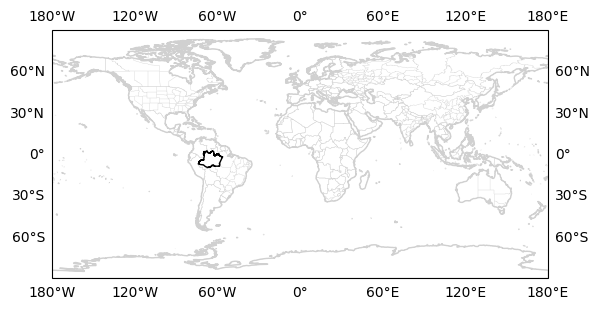

In [9]:
obs_dataset = xr.open_mfdataset(obs_dataset_path)

# filter time
obs_dataset = eea.filter.filter_time(obs_dataset, months=[12, 1, 2])

# filter area
obs_dataset = eea.filter.filter_area(obs_dataset[['t2m']], mask=mask_name, plot_area=True)

It is a good idea to check if the filter worked, so we make a plot to make sure of it.

<GeoAxes: title={'center': 'time = 1981-01-01'}>

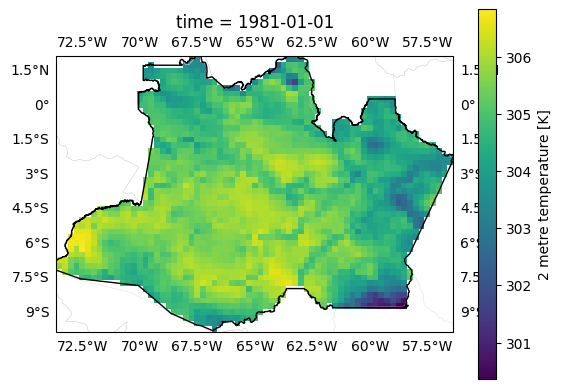

In [10]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# select the first time step
obs_dataset['t2m'].isel(time=0).plot(ax=ax)

eea.utils.add_features(ax, shapename=mask_name)

After that we can calculate an spatial average or maximum, for example, and calculate the index that we want to use to represent the extreme event. For example, we could represent a precipitation event that led to a flooding by a maximum one day precipitation, or an extreme heatwave event by a maximum of one day of maximum temperature, or use even longer timescales. We use the `eea.indice.xclim_indice` because of the `xclim` package in python that has most of those metrics already implemeneted. We are goin to use `tx_max` just as an example, but I encourage you look at their documentation to see if any other indice might be worth it [Xclim](https://xclim.readthedocs.io/en/stable/):

In [21]:
# calculate the area mean
obs_dataset_mean = obs_dataset.mean(dim=['longitude', 'latitude'], keep_attrs=True)

# calculate maximum one day temperature
obs_dataset_indice = eea.indice.xclim_indice(obs_dataset_mean, 'tx_max', tasmax='t2m', freq= 'YE-NOV')

# load data into memory
obs_dataset_indice = obs_dataset_indice.load()

After that we can do some exploratory analysis to evaluate how extreme the event was in the meteorological sense. For that we are going to use the `eea.exploratory.timeseries_plot` which plots the variable of interest highlighting the year we want to analyze (2015). Also, we can use the `eea.exploratory.rp_plot` to look for the recurrency of the event, and see how likely is this event in the meteorological series.

It is important to notice that we should use a fit function, which could be a GEV, Normal, Gamma, etc. to represent the data. This is specially important in extreme events because the results can change considerably from calculating the metrics based on couting the data in the tail of the distribution. For that we use the available fit functions from `scipy.stats` [Scipy](https://docs.scipy.org/doc/scipy/reference/stats.html).

/home/rafael/miniconda3/envs/impact-env/lib/python3.10/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rafael/miniconda3/envs/impact-env/lib/python3.10/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/rafael/miniconda3/envs/impact-env/lib/python3.10/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/home/rafael/miniconda3/envs/impact-env/lib/python3.10/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated 

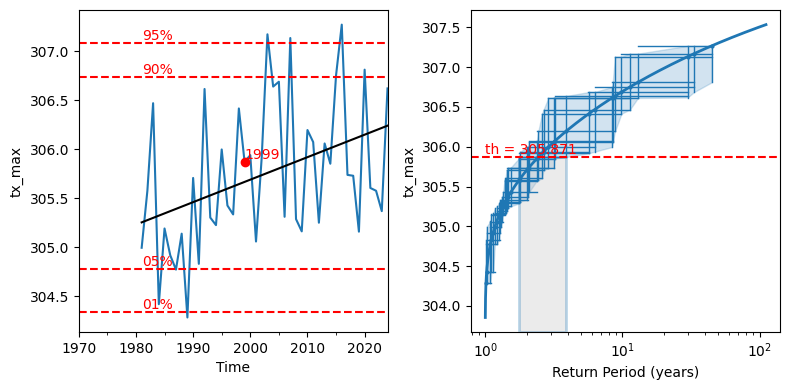

In [20]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8,4))

eea.exploratory.timeseries_plot(ax1, obs_dataset_indice, highlight_year=2015)
eea.exploratory.rp_plot(ax2, obs_dataset_indice, scipy.stats.genextreme, highlight_year=2015)

ax1.set_xlabel('Time')
ax1.set_ylabel('tx_max')
ax2.set_xlabel('Return Period (years)')
ax2.set_ylabel('tx_max')

plt.tight_layout()

# Validating the model

It is important to check if the model is correctly representing the observations for the variable of interest. We can do that in many different ways, so we developed a few functions to help us do that. The first one is the `eea.validation.qq_plot_theoretical` which is a quantile-quantile plot (QQ plot) that compares the data which a theorical function, like GEV, or Normal that we can use to evaluate if the fit function that we selected is appropriate. If it is not we can try other functions from scipy.

For that we are first going to preprocess the data for the ALL simulation.

In [ ]:
# ALL
all_dataset = eea.utils.multiens_netcdf(all_dataset_path)
all_dataset = eea.filter.filter_time(all_dataset, itime='2005-01-01', etime='2015-12-31', months=[12, 1, 2])
all_dataset = eea.filter.filter_area(all_dataset[['tasmax']], mask=mask_name, plot_area=True)

all_dataset_mean = all_dataset.mean(dim=['lon', 'lat'])
all_dataset_indice = eea.indice.xclim_indice(all_dataset_mean, 'tx_max', {'tasmax': 'tasmax', 'freq': 'YE-NOV'})

In [ ]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8,4))

eea.validation.qq_plot_theoretical(ax1, obs_dataset_mean['tx_max'], scipy.stats.genextreme)
eea.validation.qq_plot_theoretical(ax2, all_dataset_mean['tx_max'], scipy.stats.genextreme)

ax1.set_title('OBS')
ax2.set_title('ALL')

ax1.set_xlabel('Theoretical Percentiles')
ax1.set_ylabel('tx_max')
ax2.set_xlabel('Theoretical Percentiles')
ax2.set_ylabel('tx_max')

plt.tight_layout()

The second one is `eea.validation.histogram_plot` which is the histogram validation plot that compares the distributions of the model and the observation. The other one is `eea.validation.qq_plot` which makes the QQ plot between the observation and model data so we can check how well the model performs.

In [ ]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8,4))

eea.validation.histogram_plot(ax1, obs_dataset_mean['tx_max'], all_dataset_mean['tx_max'], scipy.stats.genextreme)
eea.validation.qq_plot(ax2, obs_dataset_mean['tx_max'], all_dataset_mean['tx_max'])

ax1.set_xlabel('tx_max')
ax1.set_ylabel('PDF')
ax2.set_xlabel('OBS')
ax2.set_ylabel('ALL')

plt.tight_layout()

# Attribution Analysis

For the attribution analysis, we are going to evaluate how the probabability of such an event or more extreme has changed from the natural scenario (NAT) and the all forcings scenario (ALL). For that, we are going to evaluate metrics like the Probability Ratio (PR), Fraction of Attributable Risk (FAR) and the Return Period (RP) of each scenario.

For that we are first going to preprocess the data for the NAT simulation.

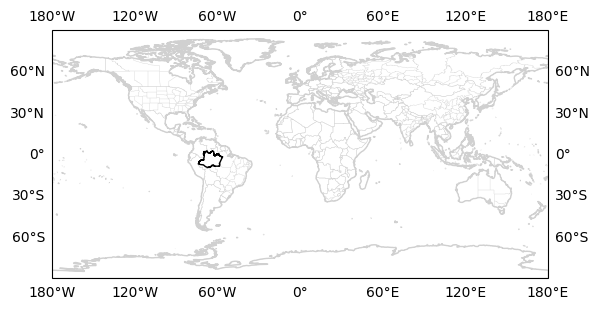

NameError: name 'all_dataset' is not defined

In [5]:
# NAT
nat_dataset = eea.utils.multiens_netcdf(nat_dataset_path)
nat_dataset = eea.filter.filter_time(nat_dataset, itime='2005-01-01', etime='2015-12-31', months=[12, 1, 2])
nat_dataset = eea.filter.filter_area(nat_dataset[['tasmax']], mask=mask_name, plot_area=True)

nat_dataset_mean = all_dataset.mean(dim=['lon', 'lat'])
nat_dataset_indice = eea.indice.xclim_indice(nat_dataset_mean, 'tx_max', {'tasmax': 'tasmax', 'freq': 'YE-NOV'})

We are now going to load the datasets into memory to speed up the next steps (this may take a while)

In [ ]:
# calculate the area average of both datasets
all_dataset_indice = all_dataset_indice.load()
nat_dataset_indice = nat_dataset_indice.load()

Now we are going to do the figures that help us visualize the changes from NAT and ALL. The `eea.attribution.histogram_plot` plots both histograms (NAT and ALL), with the threshold from the event so we can see how different the areas of the scenarios are, which means how much the probabilities of the events have changed. The second plot is the return period plot `eea.attribution.rp_plot` which shows the recurrency of the event in years, so we can evaluate how the recurrency of the event have changed from NAT to ALL, or look at a fixed RP to see how the magnitude of this type of event changed.

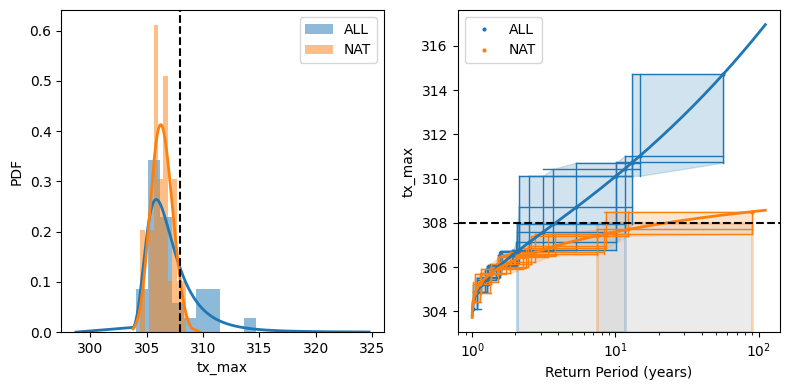

In [13]:
# plot histogram and RP plot to compare ALL and NAT
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8,4))

eea.attribution.histogram_plot(ax1, all_dataset_mean, nat_dataset_mean, scipy.stats.genextreme, 308)
eea.attribution.rp_plot(ax2, all_dataset_mean, nat_dataset_mean, scipy.stats.genextreme, 308)

ax1.set_xlabel('tx_max')
ax1.set_ylabel('PDF')
ax2.set_xlabel('Return Period (years)')
ax2.set_ylabel('tx_max')

plt.tight_layout()

Now we are going to put some numbers into it! using the `eea.attribution.attribution_metrics` we can calculate PR and FAR with the confidence intervals calculate based bootstrap.

In [14]:
eea.attribution.attribution_metrics(all_dataset_mean, nat_dataset_mean, scipy.stats.genextreme, 308)

/home/rafael/oxford/climattr/notebooks/climattr/attribution.py:305: RuntimeWarning: divide by zero encountered in scalar divide
  pr = fit_function.sf(thresh, *params_all) \
/home/rafael/oxford/climattr/notebooks/climattr/attribution.py:386: RuntimeWarning: divide by zero encountered in scalar divide
  rp = 1 / fit_function.sf(thresh, *params)
/home/rafael/miniconda3/envs/impact-env/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,value,ci_inf,ci_sup
PR,6.399636,1.897413,NaN
FAR,0.843741,0.472966,1.000000
RP_ALL,3.947950,2.563581,7.421341
RP_NAT,24.201261,9.247377,NaN


In [2]:
# Open multiple ensemble files
obs = eea.utils.multiens_netcdf(
    '/home/rafael/USP/random/cmip6_attribution/ACCESS-ESM1-5/historical/tas_day_*'
)

# filter for DJF (months we want to see)
obs = obs.where(obs['time.month'].isin([12, 1, 2]))

# calculate climdex max temperature indice
with xclim.set_options(check_missing="pct", missing_options={"pct": dict(tolerance=1)}):
    obs = xclim.indicators.atmos.tx_max(tasmax='tas', freq='YE-NOV', ds=obs)

# filter area and reduce it using mean
obs = eea.spatial.filter_area(obs, box=[0, 360, -90, 90]).mean(dim=['lat', 'lon'])

# load dataset to memory
obs = obs.load()

/home/rafael/miniconda3/envs/test-env/lib/python3.10/site-packages/xclim/core/cfchecks.py:42: UserWarning: Variable has a non-conforming cell_methods: Got `area: time: mean`, which do not include the expected `time: maximum`
  _check_cell_methods(
